# Action PixelBytes: Catching Insights in Unified Multimodal Sequences

## Description

**PixelBytes** est un modèle conçu pour générer simultanément du texte, des images, des animations pixel par pixel et des actions-états sous forme de séquences. L'objectif de ce projet est d'explorer un embedding unifié permettant une génération multimodale cohérente, facilitant ainsi l'interaction entre différentes formes de données. [Dépôt GitHub PixelBytes](https://github.com/fabienfrfr/PixelBytes)

## Dataset

Pour ce projet, nous utilisons un dataset créé à partir d'un contrôle optimal LQG (combinant LQR et un filtre de Kalman) sur des systèmes LTI contrôlables, stables et observables.

## Test

Nous testons la génération d'un problème de contrôle à partir d'un environnement Gym personnalisé pour les systèmes LTI. [Dépôt GitHub Gym-Setpoint](https://github.com/fabienfrfr/Gym-Setpoint)

In [3]:
!pip install -q git+https://github.com/fabienfrfr/PixelBytes.git@main
!pip install -q -U git+https://github.com/fabienfrfr/Gym-Setpoint@main

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.15 requires gymnasium==0.29.0, but you have gymnasium 0.29.1 which is incompatible.


In [37]:
import gymnasium as gym
import gym_setpoint
# custom import
from gym_setpoint.envs import gym_wrap, lti_env, multi_lti
from pixelbytes import *
from datasets import load_dataset
import pylab as plt
from tqdm import tqdm

In [24]:
dataset = load_dataset("ffurfaro/PixelBytes-OptimalControl")['train']
dataset

Dataset({
    features: ['audio', 'text'],
    num_rows: 9370
})

In [70]:
DATA_REDUCTION = {"image":1, "audio":1} # important pour la proportion des data en AR (overfitting audio risk)
#tokenizer = ActionPixelBytesTokenizer(data_slicing=DATA_REDUCTION)
MIN_BYTES = [b'\x00', b'\t', b'\n', b'0', b'1']
MIN_PALETTE = generate_palette(num_colors=5)
ACTION_STATE= generate_action_space(141)
tokenizer = ActionPixelBytesTokenizer(BYTES=MIN_BYTES, PALETTE=MIN_PALETTE, ACTION_STATE=ACTION_STATE, data_slicing=DATA_REDUCTION)

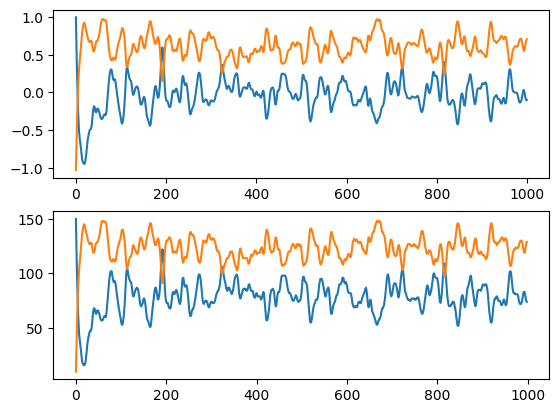

In [72]:
row = np.random.randint(dataset.num_rows)
timestamp = dataset[row]['audio']
# comparizons
tokenstamp = tokenizer(audio=timestamp)
fig, ax = plt.subplots(2)
ax[0].plot(timestamp['array'].T)
ax[1].plot(tokenstamp["labels"].detach().reshape(-1,2)[:-2]); plt.show()

In [39]:
model = aPxBySequenceModel.from_pretrained("ffurfaro/aPixelBytes-OptimalControl", subfolder="bilstm_diffusion_last")
model.config

ModelConfig {
  "_name_or_path": "ffurfaro/aPixelBytes-OptimalControl",
  "architectures": [
    "aPxBySequenceModel"
  ],
  "bidirection": true,
  "custom_model": null,
  "embed_size": 126,
  "hidden_size": 128,
  "num_diffusion_steps": 5,
  "num_layers": 2,
  "objective": "diffusion",
  "pxby_dim": 6,
  "pxby_emb": 21,
  "torch_dtype": "float32",
  "transformers_version": "4.44.2",
  "vocab_size": 151
}

In [76]:
# Create and use LTI-Env
env = lti_env.LtiEnv(custom_config={
              "env_mode":0,
              "reset_X_start":False,
              "tf":[([1],[1,1])],
              "setpoint": 0.5,
              "t":20,
              "N":1000+2})
print(env.ss, env.config['tf'], env.setpoint, env.sign)

i           1
s           1
A    [[-1.0]]
B     [[1.0]]
C     [[1.0]]
D     [[0.0]]
dtype: object [([1], [1, 1])] 0.5 1.0


100%|██████████| 1000/1000 [00:06<00:00, 150.75it/s]


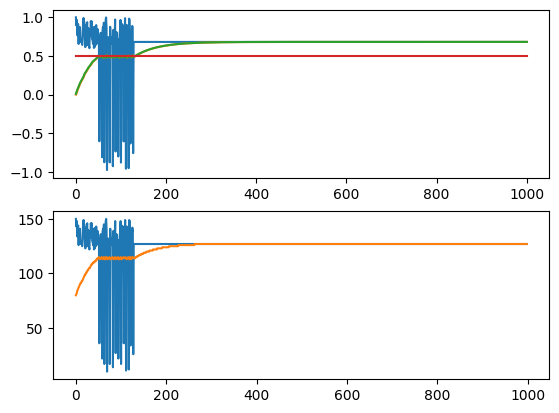

In [78]:
observation, info = env.reset()
obs = [observation]
for i in tqdm(range(1000)): 
    if i < 128 : # Bang-bang control for first step
        action = 0.8*env.sign*np.sign(np.diff(observation[-2:])) + 0.2*env.action_space.sample()
    else : # model control with  
        timestamps = {'array': np.stack(obs).T[[0,2]]}
        tokenstamp = tokenizer(audio=timestamps)
        ### here apply diffusion generation :)
    observation, reward, terminated, truncated, info = env.step(action)
    obs.append(observation)
fig, ax = plt.subplots(2)
ax[0].plot(obs)
ax[1].plot(tokenstamp["labels"].detach().reshape(-1,2)[:-2]); plt.show()